In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import numpy as np
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
from itertools import permutations
from collections import namedtuple, deque

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [3]:
C = axl.Action.C
D = axl.Action.D

# config game rules
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [4]:
# the play function set up match between 2 players, print the result then return the match object
game = play(axl.Prober4(), axl.TitForTat())
game

[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0)]
Player 1 score = 50
Player 2 score = 45


In [5]:
# this is how we define state, in 2d array    (3d for batch training)

s = State(GAME_LEN)
s.push(C, D)
print(s.values())

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]]


### Section 1: DQN

In [6]:
dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [7]:
with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_value predictions:

[[ 0.423 -0.389]]
[[ 0.245 -0.885]]
[[-0.409 -0.327]]
[[-0.277 -0.208]]
[[-0.87   0.432]]
[[-0.377  0.318]]
[[-0.858 -0.49 ]]
[[-0.908  0.655]]
[[-0.215  0.708]]
[[-0.008  0.804]]
[[0.582 0.184]]
[[0.35  0.309]]
[[-0.567  0.838]]
[[-0.825  0.605]]
[[-1.047  0.146]]
[[-0.044  0.265]]
[[0.388 0.709]]
[[-0.309  0.544]]
[[-0.299 -0.28 ]]
[[0.207 0.502]]
[[0.923 0.353]]


In [8]:
# initial experience
# high greedy -> more random exploration

p1.set_greedy(0.8)
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
p1.set_greedy(0.2)

In [9]:
# theoritical Q values
# assuming the player cooperate til the last turn, then defect
# annuity with cashflow = 3.0, interest rate = 1/9, periods = 20 turns
# then compensate the defection in 2nd last turn, and set last turn to 0.0
true_Q = np.array([3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 5.0 if i<20 else 0.0 for i in range(21)])
[print(f'{i:.2f}') for i in true_Q];

28.35
27.95
27.50
27.00
26.44
25.82
25.14
24.37
23.53
22.59
21.54
20.38
19.09
17.65
16.06
14.29
12.32
10.13
7.70
5.00
0.00


In [10]:
# training loop

score_ls = []
errors = []
for _ in range(20):
    start = time()
    p1.train(30, param)
    
    # collect new experience with trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # calculating Q-value error for later use
    # a bit tedious here but I'm too lazy to fix
    values = []
    state = State(21)
    for i in range(21):
        value = p1.network(state.values())[0]
        values.append(value[0])
        state.push(C, C)
    error = true_Q - np.array(values)
    errors.append(error)


# left: running loss for cooperation
# right: running loss for defection

loss: [0.227 0.286],            time: +4.50 sec
loss: [0.179 0.15 ],            time: +4.20 sec
loss: [0.11  0.106],            time: +4.91 sec
loss: [0.085 0.083],            time: +7.20 sec
loss: [0.07  0.072],            time: +7.02 sec
loss: [0.071 0.058],            time: +5.11 sec
loss: [0.049 0.039],            time: +5.25 sec
loss: [0.038 0.036],            time: +5.67 sec
loss: [0.034 0.028],            time: +5.25 sec
loss: [0.028 0.032],            time: +5.39 sec
loss: [0.025 0.037],            time: +6.02 sec
loss: [0.024 0.028],            time: +5.54 sec
loss: [0.031 0.033],            time: +5.40 sec
loss: [0.027 0.035],            time: +5.20 sec
loss: [0.022 0.031],            time: +5.35 sec
loss: [0.029 0.028],            time: +5.34 sec
loss: [0.017 0.019],            time: +5.37 sec
loss: [0.015 0.026],            time: +5.23 sec
loss: [0.019 0.02 ],            time: +5.37 sec
loss: [0.025 0.028],            time: +5.22 sec


In [17]:
with p1:
    play(p1, axl.TitForTat())
# predicted Q-values:

[[26.802 26.088]]
[[26.197 25.516]]
[[25.703 25.018]]
[[25.354 24.596]]
[[24.855 24.235]]
[[24.379 23.688]]
[[23.76  23.144]]
[[22.982 22.266]]
[[22.1   21.403]]
[[21.271 20.635]]
[[20.265 19.622]]
[[19.209 18.491]]
[[18.098 17.327]]
[[16.696 16.07 ]]
[[15.202 14.506]]
[[13.542 12.828]]
[[11.762 11.109]]
[[9.75  9.069]]
[[7.49  5.873]]
[[2.992 4.995]]
[[-0.011 -0.024]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


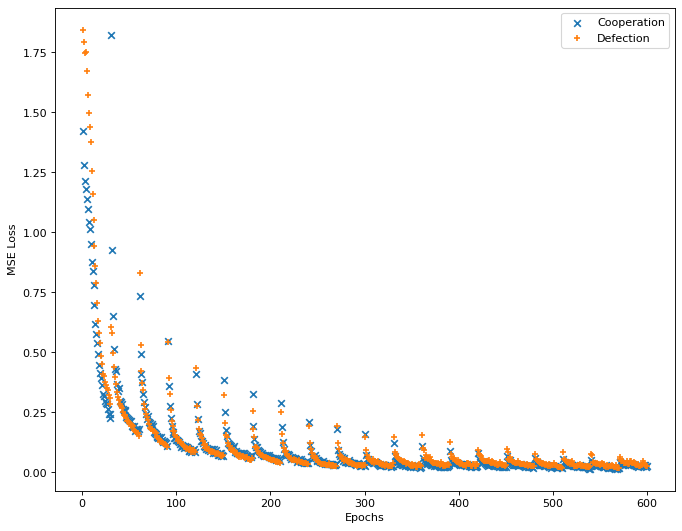

In [18]:
# training loss
# the beauty of double DQN
p1.plot()

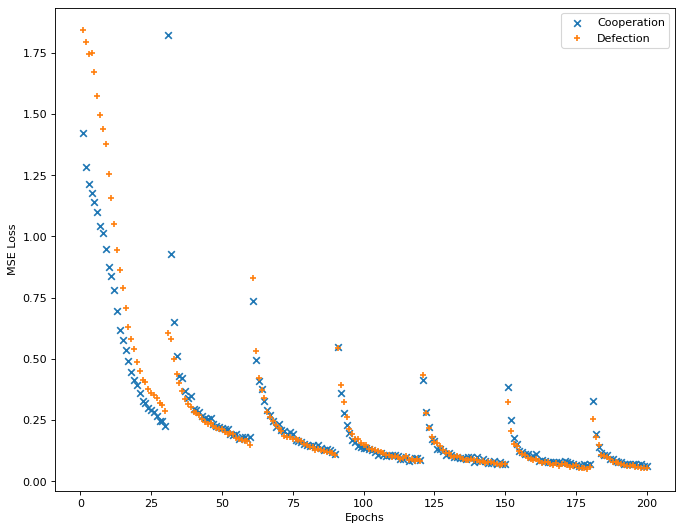

In [19]:
# zoom in first 200 epochs
p1.plot(min_ran=0, max_ran=200)

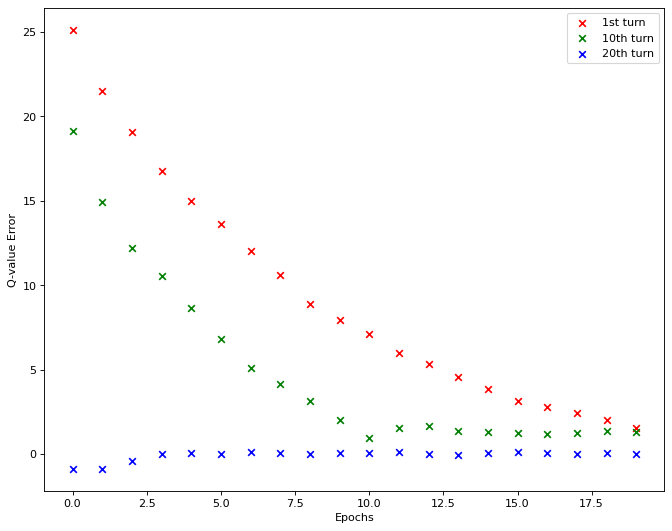

In [20]:
# visualizing the recursion nature of Bellman's equation,
# where the later states has to be learnt prior to learning preceding states

# plotting the error between our prediction against the theoritical Q-value
errors = np.array(errors)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(errors)), errors[:,0], c='r', marker='x', label='1st turn')
plt.scatter(range(len(errors)), errors[:,9], c='g', marker='x', label='10th turn')
plt.scatter(range(len(errors)), [e[19]-2 for e in errors], c='b', marker='x', label='20th turn')  # compensate for defection
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Q-value Error')
plt.show()

### Section 2: DQN without fixed target (single DQN)

In [25]:
dqn2 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn2, State(GAME_LEN))
del dqn2
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

p2.set_greedy(0.8)
for i in range(60):
    players = (p2, axl.TitForTat())
    game = Match(players)
    game.play()
p2.set_greedy(0.2)

for _ in range(100):
    start = time()
    
    p2.train(1, param)  # my train function updates target net at the end via deepcopy, we can overwrite this by
    p2.network.target_net = p2.network.policy_net  # SHALLOW COPY policy net to target net
    
    [Match((p2, axl.TitForTat())).play() for _ in range(10)]
    print(f'loss: {p2.network.loss},            time: +{time()-start:.2f} sec')

loss: [1.372 4.137],            time: +0.43 sec
loss: [1.868 4.592],            time: +0.50 sec
loss: [1.927 4.346],            time: +0.52 sec
loss: [1.883 4.423],            time: +0.56 sec
loss: [1.872 4.107],            time: +0.54 sec
loss: [1.863 3.571],            time: +0.59 sec
loss: [2.133 2.841],            time: +0.61 sec
loss: [2.365 2.798],            time: +0.55 sec
loss: [2.612 2.599],            time: +0.53 sec
loss: [2.685 2.296],            time: +0.50 sec
loss: [2.971 2.434],            time: +0.51 sec
loss: [3.436 2.496],            time: +0.48 sec
loss: [3.591 2.286],            time: +0.45 sec
loss: [4.201 2.306],            time: +0.51 sec
loss: [4.6   2.385],            time: +0.45 sec
loss: [5.193 2.581],            time: +0.47 sec
loss: [5.871 3.072],            time: +0.46 sec
loss: [6.179 3.74 ],            time: +0.48 sec
loss: [6.936 4.41 ],            time: +0.51 sec
loss: [7.79  5.411],            time: +0.57 sec
loss: [9.105 6.268],            time: +0

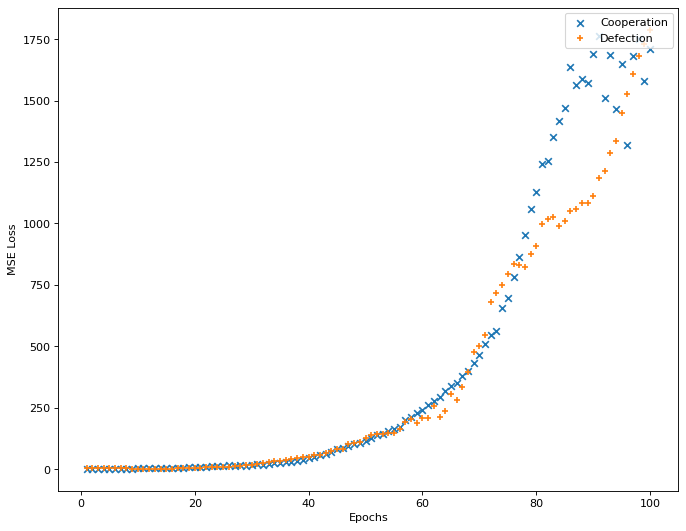

In [26]:
p2.plot()

In [27]:
# result:
with p2:
    play(p2, axl.TitForTat())
    
# incorrect Q-values -> bad policy

[[ -1.125 506.687]]
[[-1753.156 -1110.922]]
[[ 863.245 1387.122]]
[[4346.188 4717.895]]
[[-2608.388 -1928.316]]
[[ 701.706 1243.7  ]]
[[1787.485 2249.329]]
[[1732.33  2207.551]]
[[-1187.527  -589.858]]
[[104.231 625.798]]
[[-258.622  251.594]]
[[521.191 978.212]]
[[1433.155 1789.808]]
[[ 701.215 1058.789]]
[[-485.435  -92.778]]
[[-556.248 -210.785]]
[[371.641 615.445]]
[[-472.9   -226.942]]
[[205.934 351.298]]
[[507.168 596.36 ]]
[[202.38 256.72]]
[(5, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 24
Player 2 score = 19


In [28]:
del p2

### Section 3: testing the off-policyness

In [29]:
from axl_utils.extract import extract

In [30]:
# collecting experience from axl.Random
memory = network.ReplayMemory(10000)
for _ in range(500):
    game = play(axl.Random(), axl.TitForTat(), show=False)
    extract(game, memory)

In [31]:
dqn3 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            memory, gamma=0.9, greedy=0.2)  # <- feeding the memory from axl.Random
p3 = NNplayer(dqn3, State(GAME_LEN))
del dqn3
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [32]:
for _ in range(20):
    start = time()
    p3.train(5, param)
    print(f'loss: {p3.network.loss},            time: +{time()-start:.2f} sec')

loss: [0.271 0.289],            time: +5.57 sec
loss: [0.255 0.227],            time: +4.72 sec
loss: [0.193 0.186],            time: +5.11 sec
loss: [0.155 0.174],            time: +4.65 sec
loss: [0.143 0.146],            time: +4.75 sec
loss: [0.128 0.154],            time: +4.53 sec
loss: [0.116 0.127],            time: +4.81 sec
loss: [0.113 0.121],            time: +5.62 sec
loss: [0.105 0.109],            time: +6.22 sec
loss: [0.102 0.103],            time: +5.80 sec
loss: [0.085 0.091],            time: +5.51 sec
loss: [0.087 0.09 ],            time: +6.71 sec
loss: [0.092 0.093],            time: +4.43 sec
loss: [0.072 0.083],            time: +6.04 sec
loss: [0.075 0.077],            time: +5.50 sec
loss: [0.067 0.071],            time: +5.97 sec
loss: [0.062 0.067],            time: +5.77 sec
loss: [0.07  0.064],            time: +5.91 sec
loss: [0.065 0.064],            time: +4.83 sec
loss: [0.057 0.061],            time: +6.46 sec


In [33]:
with p3:
    play(p3, axl.TitForTat())
    
# learns exactly the same

[[26.541 25.857]]
[[26.162 25.454]]
[[25.569 24.847]]
[[25.047 24.444]]
[[24.489 23.89 ]]
[[23.897 23.322]]
[[23.264 22.635]]
[[22.448 21.951]]
[[21.727 21.075]]
[[20.986 20.482]]
[[20.041 19.657]]
[[18.895 18.59 ]]
[[17.738 17.058]]
[[16.347 15.723]]
[[15.261 14.463]]
[[13.677 13.017]]
[[11.579 10.78 ]]
[[9.771 9.2  ]]
[[7.693 6.159]]
[[2.95  5.112]]
[[0.074 0.197]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


In [34]:
del p3

### Section 4: but what did it learn?

In [25]:
# might be an obvious question but let's see what happens if our DQN meets provocative defection

p1.network.greedy = 0.0
play(p1, axl.HardProber());  # hard prober defects forever if its opponent does not retaliate

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (1, 1)]
Player 1 score = 7
Player 2 score = 92


In [26]:
play(axl.Cooperator(), axl.HardProber());  # => our DQN is basically a naive cooperator

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)]
Player 1 score = 6
Player 2 score = 96


In [27]:
play(axl.TitForTat(), axl.HardProber());  # while TFT can generalize well to any opponent

[(0, 5), (1, 1), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 57
Player 2 score = 57


In [28]:
# => continue exploration on Stage 2

### Section 5: learning TFT with 2 perceptrons

In [29]:
# possible states of last turn
# where [1,1] means mutual cooperation
X = np.array([[1,1],[0,1],[1,0],[0,0]])

# target
# => copy opponent's action
y = np.array([[1],[1],[0],[0]])

nn = network.NeuralNetwork([network.Linear_layer(2, 1)])
param = {"lr": 3e-2, 'batch': 2, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [30]:
for i in range(40):
    nn.train(X, y, param)
    yhat = np.round(nn(X))
    acc = np.sum(yhat==y) / len(y)
    print(f"Epoch {i}, Accuracy = {acc}")

Average loss = 0.595053, elapsed time = 0.00.
Epoch 0, Accuracy = 0.5
Average loss = 0.533621, elapsed time = 0.00.
Epoch 1, Accuracy = 0.5
Average loss = 0.494105, elapsed time = 0.00.
Epoch 2, Accuracy = 0.5
Average loss = 0.429417, elapsed time = 0.00.
Epoch 3, Accuracy = 0.5
Average loss = 0.385835, elapsed time = 0.00.
Epoch 4, Accuracy = 0.75
Average loss = 0.349568, elapsed time = 0.00.
Epoch 5, Accuracy = 0.75
Average loss = 0.322200, elapsed time = 0.00.
Epoch 6, Accuracy = 0.5
Average loss = 0.277924, elapsed time = 0.00.
Epoch 7, Accuracy = 0.5
Average loss = 0.250987, elapsed time = 0.00.
Epoch 8, Accuracy = 0.5
Average loss = 0.231781, elapsed time = 0.00.
Epoch 9, Accuracy = 0.5
Average loss = 0.209439, elapsed time = 0.00.
Epoch 10, Accuracy = 0.75
Average loss = 0.181862, elapsed time = 0.00.
Epoch 11, Accuracy = 0.75
Average loss = 0.166591, elapsed time = 0.00.
Epoch 12, Accuracy = 0.75
Average loss = 0.150162, elapsed time = 0.00.
Epoch 13, Accuracy = 0.75
Average lo

In [31]:
# but this is more of a policy-gradient approach
# the regression nature of DQNs make it impossible to employ simple architecture